In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import exposure
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from sklearn.feature_selection import SelectKBest, f_classif
import cv2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier


In [8]:
df = pd.read_csv('data/train.csv')

In [9]:
df

,im_name,label
0,00016cd.jpg,6
1,0001808.jpg,2
2,0002399.jpg,1
3,0003973.jpg,3
4,00061cc.jpg,4
...,...,...
49995,d5992c0.jpg,7
49996,d599cf6.jpg,9
49997,d59a4c9.jpg,5
49998,d59c7f5.jpg,9


In [10]:
def read_image(path: str):
    return Image.open(path)

In [11]:
img = read_image('data/train_ims/d59d147.jpg')
img.size

(32, 32)

# 1. Dataset Analysis

### Statistics on the number of categories

In [12]:
# Total number of unique categories

num_categories = df['label'].nunique()
print(f"Number of unique categories: {num_categories}")

Number of unique categories: 10


In [13]:
# Number of images per category

df['label'].value_counts().sort_index()

label
0    5010
1    5012
2    5038
3    5007
4    4995
5    4993
6    4955
7    5000
8    5020
9    4970
Name: count, dtype: int64

### Visualization of example per category

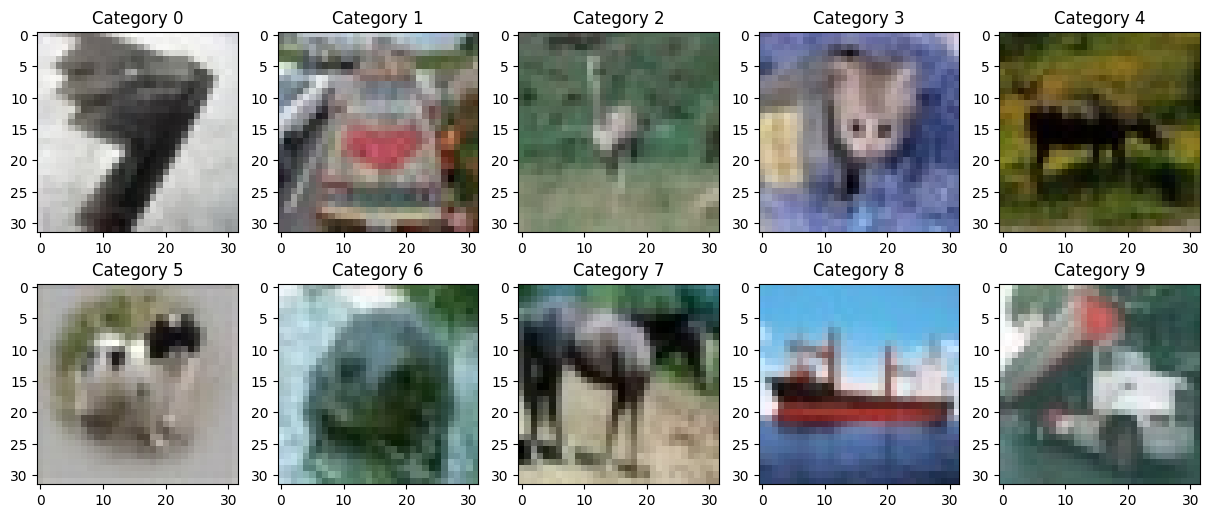

In [14]:
example_per_category = df.groupby('label').first().reset_index()
num_categories = example_per_category.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, (i, row) in enumerate(example_per_category.iterrows()):
    row_idx = idx // 5
    col_idx = idx % 5
    ax = axes[row_idx, col_idx]

    img = read_image(os.path.join('data', 'train_ims', row['im_name']))
    ax.imshow(img)
    ax.set_title(f'Category {row['label']}')

In [15]:
def gabor_features(image):
    filters = []
    ksize = 21  # Smaller filter size
    for theta in np.arange(0, np.pi, np.pi / 4):  # Fewer orientations
        for sigma in (1, 2):
            for lamda in np.pi / np.array([4, 8]):  # Specific wavelengths
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma=0.5)
                filters.append(kernel)
    filtered_imgs = [cv2.filter2D(image, cv2.CV_8UC3, k) for k in filters]
    features = np.array([img.mean() for img in filtered_imgs])
    return features



def extract_features(image):
    gray_img = rgb2gray(image)
    equalized_img = exposure.equalize_hist(gray_img)
    hog_features = hog(
        equalized_img,
        orientations=16,
        pixels_per_cell=(8, 8),
        cells_per_block=(3, 3),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )

    # LBP Features
    lbp = local_binary_pattern(equalized_img, P=32, R=4, method='nri_uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize histogram
    
    gabor_feats = gabor_features(equalized_img)
    
    # Combine All Features
    features = np.concatenate((hog_features, lbp_hist, gabor_feats))
    return features

# Train

In [16]:
# Features Extractions
features_list = []
labels = []
IMG_DIR = 'data/train_ims'

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_path = os.path.join(IMG_DIR, row['im_name'])
    img = imread(img_path)

    features = extract_features(img)
    features_list.append(features)
    labels.append(row['label'])


X = np.array(features_list)
y = np.array(labels)

  0%|          | 0/50000 [00:00<?, ?it/s]

/Users/mmmo/Library/Caches/pypoetry/virtualenvs/comp3314-asg3-7gkLUL7O-py3.12/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 50000/50000 [00:59<00:00, 843.87it/s]


In [39]:
# Pre-processing


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Selector
selector = SelectKBest(f_classif, k=500)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_selected)
X_val = pca.transform(X_val_selected)


In [23]:
# Models
from sklearn.ensemble import HistGradientBoostingClassifier

clf1 = SVC(kernel='rbf', C=5.0, gamma='scale', probability=True, random_state=42)
clf2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
clf3 = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, random_state=42)
clf4 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    njobs=-1
)

eclf = VotingClassifier(estimators=[
        ('svc', clf1),
        ('rf', clf2),
        ('gb', clf3),
        ('xgb', clf4)
    ],
    voting='soft'
)

eclf.fit(X_train, y_train)

/Users/mmmo/Library/Caches/pypoetry/virtualenvs/comp3314-asg3-7gkLUL7O-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "njobs", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('svc',
                              SVC(C=5.0, probability=True, random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('gb',
                              HistGradientBoostingClassifier(learning_rate=0.05,
                                                             max_iter=300,
                                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsamp...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            njobs=-1, num_parallel_tree=None, ...))],
                 voting='soft')

In [24]:
y_pred = eclf.predict(X_val)

In [25]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy}')

Validation accuracy: 0.584


# Test

In [34]:
test_df = pd.read_csv("data/test.csv")
test_image_names = test_df['im_name'].tolist()

TEST_IMAGE_DIR = 'data/test_ims'
X_test = []
for img_name in tqdm(test_image_names):
    img_path = os.path.join(TEST_IMAGE_DIR, img_name)
    img = imread(img_path)
    features = extract_features(img)
    X_test.append(features)

X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/mmmo/Library/Caches/pypoetry/virtualenvs/comp3314-asg3-7gkLUL7O-py3.12/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 10000/10000 [00:11<00:00, 875.54it/s]


In [31]:
X_test_scaled.shape

(10000, 1587)

In [40]:
# Selector
# selector = SelectKBest(f_classif, k=500)
X_test_selected = selector.transform(X_test_scaled)




In [42]:
# PCA
X_test = pca.transform(X_test_selected)

In [43]:
y_test_pred = eclf.predict(X_test)

In [44]:
submission_df = pd.DataFrame({
    'im_name': test_image_names,
    'label': y_test_pred
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)
